In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 128

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 128)   768         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 128)   512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 128)   768         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 128)   512         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 128)   0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 128)   768         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 128)   512         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3332 - acc: 0.2568
Epoch 00001: val_loss improved from inf to 2.22321, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_3_conv_checkpoint/001-2.2232.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 2.3331 - acc: 0.2568 - val_loss: 2.2232 - val_acc: 0.3103
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0156 - acc: 0.3562
Epoch 00002: val_loss improved from 2.22321 to 1.80722, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_3_conv_checkpoint/002-1.8072.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 2.0156 - acc: 0.3562 - val_loss: 1.8072 - val_acc: 0.5022
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8671 - acc: 0.4109
Epoch 00003: val_loss improved from 1

36800/36805 [============================>.] - ETA: 0s - loss: 1.1740 - acc: 0.6429
Epoch 00024: val_loss did not improve from 1.06898
36805/36805 [==============================] - 103s 3ms/sample - loss: 1.1739 - acc: 0.6429 - val_loss: 1.1319 - val_acc: 0.6492
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1577 - acc: 0.6428
Epoch 00025: val_loss did not improve from 1.06898
36805/36805 [==============================] - 103s 3ms/sample - loss: 1.1577 - acc: 0.6428 - val_loss: 1.1809 - val_acc: 0.6315
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1548 - acc: 0.6496
Epoch 00026: val_loss improved from 1.06898 to 0.97906, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_3_conv_checkpoint/026-0.9791.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 1.1548 - acc: 0.6496 - val_loss: 0.9791 - val_acc: 0.7214
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9889 - acc: 0.7027
Epoch 00053: val_loss improved from 0.95261 to 0.94100, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_3_conv_checkpoint/053-0.9410.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.9890 - acc: 0.7027 - val_loss: 0.9410 - val_acc: 0.6888
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9912 - acc: 0.7004
Epoch 00054: val_loss did not improve from 0.94100
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.9913 - acc: 0.7004 - val_loss: 1.0620 - val_acc: 0.6562
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9835 - acc: 0.7039
Epoch 00055: val_loss did not improve from 0.94100
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.9836 - acc: 0.7039 - val_loss: 1.0435 - val_acc: 0.6746
Epoch 56/500
36800/36805 [============================>.] 

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9121 - acc: 0.7286
Epoch 00082: val_loss did not improve from 0.82296
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.9120 - acc: 0.7286 - val_loss: 1.4936 - val_acc: 0.5723
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9133 - acc: 0.7304
Epoch 00083: val_loss did not improve from 0.82296
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.9133 - acc: 0.7304 - val_loss: 3.6964 - val_acc: 0.3487
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9047 - acc: 0.7303
Epoch 00084: val_loss did not improve from 0.82296
36805/36805 [==============================] - 103s 3ms/sample - loss: 0.9047 - acc: 0.7303 - val_loss: 0.9181 - val_acc: 0.7223
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9068 - acc: 0.7292
Epoch 00085: val_loss did not improve from 0.82296
36805/36805 [========

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8595 - acc: 0.7480
Epoch 00112: val_loss did not improve from 0.82296
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.8595 - acc: 0.7481 - val_loss: 1.6267 - val_acc: 0.4596
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8494 - acc: 0.7512
Epoch 00113: val_loss did not improve from 0.82296
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.8493 - acc: 0.7512 - val_loss: 0.9148 - val_acc: 0.7014
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8495 - acc: 0.7493
Epoch 00114: val_loss did not improve from 0.82296
36805/36805 [==============================] - 102s 3ms/sample - loss: 0.8497 - acc: 0.7492 - val_loss: 6.8045 - val_acc: 0.2884
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8500 - acc: 0.7479
Epoch 00115: val_loss did not improve from 0.82296
36805/36805 [====

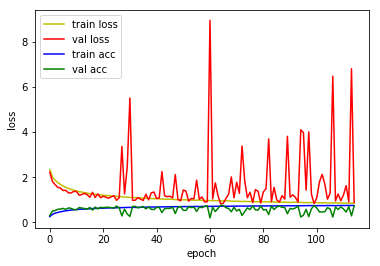

4815/4815 [==============================] - 5s 976us/sample - loss: 0.8767 - acc: 0.7310
Loss: 0.8767301782764502 Accuracy: 0.7310488

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1676 - acc: 0.3118
Epoch 00001: val_loss improved from inf to 2.00298, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_4_conv_checkpoint/001-2.0030.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 2.1675 - acc: 0.3118 - val_loss: 2.0030 - val_acc: 0.3969
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7470 - acc: 0.4530
Epoch 00002: val_loss improved from 2.00298 to 1.47085, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_4_conv_checkpoint/002-1.4708.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.7470 - acc: 0.4530 - val_loss: 1.4708 - val_acc: 0.5842
Epoch 3/500
36800/36805 [====================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8378 - acc: 0.7505
Epoch 00024: val_loss improved from 0.71792 to 0.70544, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_4_conv_checkpoint/024-0.7054.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.8378 - acc: 0.7506 - val_loss: 0.7054 - val_acc: 0.8036
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8304 - acc: 0.7537
Epoch 00025: val_loss did not improve from 0.70544
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.8303 - acc: 0.7537 - val_loss: 0.8141 - val_acc: 0.7729
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8211 - acc: 0.7561
Epoch 00026: val_loss did not improve from 0.70544
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.8211 - acc: 0.7561 - val_loss: 0.7900 - val_acc: 0.7815
Epoch 27/500
36800/36805 [============================>.] 

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6729 - acc: 0.8032
Epoch 00053: val_loss did not improve from 0.63029
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.6731 - acc: 0.8032 - val_loss: 0.7197 - val_acc: 0.7845
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6708 - acc: 0.8035
Epoch 00054: val_loss did not improve from 0.63029
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.6709 - acc: 0.8034 - val_loss: 0.7910 - val_acc: 0.7612
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6676 - acc: 0.8032
Epoch 00055: val_loss did not improve from 0.63029
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.6676 - acc: 0.8032 - val_loss: 0.9153 - val_acc: 0.7167
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6632 - acc: 0.8027
Epoch 00056: val_loss improved from 0.63029 to 0.59902, saving model to 

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5919 - acc: 0.8253
Epoch 00082: val_loss did not improve from 0.54849
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.5919 - acc: 0.8253 - val_loss: 0.9179 - val_acc: 0.7128
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5900 - acc: 0.8251
Epoch 00083: val_loss did not improve from 0.54849
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.5902 - acc: 0.8250 - val_loss: 0.7052 - val_acc: 0.7980
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5857 - acc: 0.8284
Epoch 00084: val_loss did not improve from 0.54849
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.5857 - acc: 0.8284 - val_loss: 1.1052 - val_acc: 0.6508
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5818 - acc: 0.8269
Epoch 00085: val_loss did not improve from 0.54849
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.5320 - acc: 0.8420
Epoch 00111: val_loss did not improve from 0.51303
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.5321 - acc: 0.8419 - val_loss: 0.7146 - val_acc: 0.7750
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5250 - acc: 0.8446
Epoch 00112: val_loss did not improve from 0.51303
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.5251 - acc: 0.8445 - val_loss: 0.5870 - val_acc: 0.8239
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5202 - acc: 0.8446
Epoch 00113: val_loss did not improve from 0.51303
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.5203 - acc: 0.8446 - val_loss: 0.9798 - val_acc: 0.7140
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5237 - acc: 0.8433
Epoch 00114: val_loss did not improve from 0.51303
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.4805 - acc: 0.8578
Epoch 00140: val_loss did not improve from 0.48314
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.4805 - acc: 0.8578 - val_loss: 2.8640 - val_acc: 0.4435
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4751 - acc: 0.8582
Epoch 00141: val_loss did not improve from 0.48314
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.4752 - acc: 0.8581 - val_loss: 0.5584 - val_acc: 0.8227
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4773 - acc: 0.8602
Epoch 00142: val_loss did not improve from 0.48314
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.4774 - acc: 0.8601 - val_loss: 0.5372 - val_acc: 0.8465
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4783 - acc: 0.8581
Epoch 00143: val_loss did not improve from 0.48314
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.4346 - acc: 0.8694
Epoch 00169: val_loss did not improve from 0.47411
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.4346 - acc: 0.8694 - val_loss: 0.5000 - val_acc: 0.8595
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4339 - acc: 0.8687
Epoch 00170: val_loss did not improve from 0.47411
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.4338 - acc: 0.8687 - val_loss: 0.7142 - val_acc: 0.7785
Epoch 171/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4296 - acc: 0.8717
Epoch 00171: val_loss did not improve from 0.47411
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.4296 - acc: 0.8718 - val_loss: 0.8390 - val_acc: 0.7482
Epoch 172/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4272 - acc: 0.8718
Epoch 00172: val_loss did not improve from 0.47411
36805/36805 [==================

Epoch 199/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3988 - acc: 0.8791
Epoch 00199: val_loss did not improve from 0.47411
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.3988 - acc: 0.8791 - val_loss: 1.4087 - val_acc: 0.6816
Epoch 200/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3880 - acc: 0.8824
Epoch 00200: val_loss did not improve from 0.47411
36805/36805 [==============================] - 105s 3ms/sample - loss: 0.3880 - acc: 0.8824 - val_loss: 1.8129 - val_acc: 0.5924
Epoch 201/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3982 - acc: 0.8817
Epoch 00201: val_loss did not improve from 0.47411
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.3982 - acc: 0.8817 - val_loss: 1.7782 - val_acc: 0.5840
Epoch 202/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3871 - acc: 0.8842
Epoch 00202: val_loss did not improve from 0.47411
36805/36805 [====

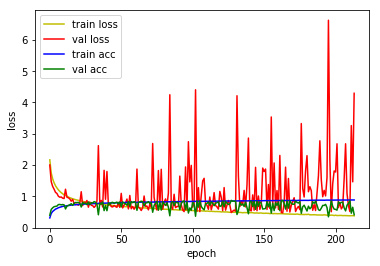

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.5631 - acc: 0.8309
Loss: 0.5630885163324025 Accuracy: 0.83094496

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8295 - acc: 0.4199
Epoch 00001: val_loss improved from inf to 1.60169, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_5_conv_checkpoint/001-1.6017.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 1.8294 - acc: 0.4199 - val_loss: 1.6017 - val_acc: 0.5625
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3160 - acc: 0.6009
Epoch 00002: val_loss improved from 1.60169 to 1.22121, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_5_conv_checkpoint/002-1.2212.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 1.3159 - acc: 0.6009 - val_loss: 1.2212 - val_acc: 0.6208
Epoch 3/500
36800/36805 [=====================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4598 - acc: 0.8685
Epoch 00025: val_loss did not improve from 0.45894
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.4598 - acc: 0.8685 - val_loss: 0.5581 - val_acc: 0.8425
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4490 - acc: 0.8708
Epoch 00026: val_loss did not improve from 0.45894
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.4489 - acc: 0.8708 - val_loss: 0.4817 - val_acc: 0.8672
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4350 - acc: 0.8735
Epoch 00027: val_loss did not improve from 0.45894
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.4350 - acc: 0.8734 - val_loss: 0.5215 - val_acc: 0.8472
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4279 - acc: 0.8781
Epoch 00028: val_loss improved from 0.45894 to 0.42303, saving model to 

36800/36805 [============================>.] - ETA: 0s - loss: 0.2793 - acc: 0.9168
Epoch 00052: val_loss did not improve from 0.34450
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.2793 - acc: 0.9168 - val_loss: 0.3920 - val_acc: 0.9015
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2818 - acc: 0.9167
Epoch 00053: val_loss improved from 0.34450 to 0.33699, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_5_conv_checkpoint/053-0.3370.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.2818 - acc: 0.9167 - val_loss: 0.3370 - val_acc: 0.9122
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2716 - acc: 0.9203
Epoch 00054: val_loss did not improve from 0.33699
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.2716 - acc: 0.9203 - val_loss: 0.3596 - val_acc: 0.9087
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1849 - acc: 0.9447
Epoch 00081: val_loss did not improve from 0.32109
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1849 - acc: 0.9447 - val_loss: 0.3534 - val_acc: 0.9122
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1843 - acc: 0.9457
Epoch 00082: val_loss did not improve from 0.32109
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1843 - acc: 0.9456 - val_loss: 0.3264 - val_acc: 0.9213
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1817 - acc: 0.9466
Epoch 00083: val_loss did not improve from 0.32109
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1817 - acc: 0.9466 - val_loss: 0.3311 - val_acc: 0.9171
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1805 - acc: 0.9458
Epoch 00084: val_loss did not improve from 0.32109
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1300 - acc: 0.9618
Epoch 00110: val_loss did not improve from 0.32088
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1302 - acc: 0.9617 - val_loss: 0.6736 - val_acc: 0.8383
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1398 - acc: 0.9575
Epoch 00111: val_loss did not improve from 0.32088
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1398 - acc: 0.9575 - val_loss: 0.3787 - val_acc: 0.9131
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1213 - acc: 0.9640
Epoch 00112: val_loss did not improve from 0.32088
36805/36805 [==============================] - 108s 3ms/sample - loss: 0.1213 - acc: 0.9640 - val_loss: 0.4208 - val_acc: 0.9015
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1239 - acc: 0.9633
Epoch 00113: val_loss did not improve from 0.32088
36805/36805 [==================

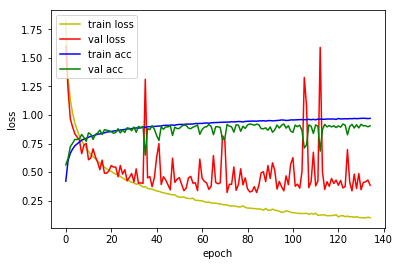

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3918 - acc: 0.8868
Loss: 0.39176324451823846 Accuracy: 0.88681203

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5835 - acc: 0.5129
Epoch 00001: val_loss improved from inf to 1.31985, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_6_conv_checkpoint/001-1.3199.hdf5
36805/36805 [==============================] - 117s 3ms/sample - loss: 1.5835 - acc: 0.5129 - val_loss: 1.3199 - val_acc: 0.6580
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9662 - acc: 0.7257
Epoch 00002: val_loss improved from 1.31985 to 0.85587, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_6_conv_checkpoint/002-0.8559.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.9665 - acc: 0.7256 - val_loss: 0.8559 - val_acc: 0.7594
Epoch 3/500
36800/36805 [====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1879 - acc: 0.9454
Epoch 00025: val_loss improved from 0.21815 to 0.21586, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_6_conv_checkpoint/025-0.2159.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1879 - acc: 0.9453 - val_loss: 0.2159 - val_acc: 0.9392
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1823 - acc: 0.9469
Epoch 00026: val_loss did not improve from 0.21586
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1823 - acc: 0.9469 - val_loss: 0.2770 - val_acc: 0.9248
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1746 - acc: 0.9486
Epoch 00027: val_loss did not improve from 0.21586
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.1746 - acc: 0.9485 - val_loss: 0.2527 - val_acc: 0.9297
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.0761 - acc: 0.9791
Epoch 00053: val_loss did not improve from 0.18451
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0761 - acc: 0.9791 - val_loss: 0.2140 - val_acc: 0.9441
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0735 - acc: 0.9787
Epoch 00054: val_loss did not improve from 0.18451
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0735 - acc: 0.9787 - val_loss: 0.2341 - val_acc: 0.9446
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0773 - acc: 0.9765
Epoch 00055: val_loss did not improve from 0.18451
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0773 - acc: 0.9765 - val_loss: 0.2005 - val_acc: 0.9471
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0744 - acc: 0.9779
Epoch 00056: val_loss did not improve from 0.18451
36805/36805 [=====================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9862
Epoch 00083: val_loss did not improve from 0.18451
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0485 - acc: 0.9862 - val_loss: 0.2498 - val_acc: 0.9399
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9899
Epoch 00084: val_loss did not improve from 0.18451
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0383 - acc: 0.9899 - val_loss: 0.2207 - val_acc: 0.9436
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9859
Epoch 00085: val_loss did not improve from 0.18451
36805/36805 [==============================] - 109s 3ms/sample - loss: 0.0457 - acc: 0.9859 - val_loss: 0.2358 - val_acc: 0.9448
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9912
Epoch 00086: val_loss did not improve from 0.18451
36805/36805 [========

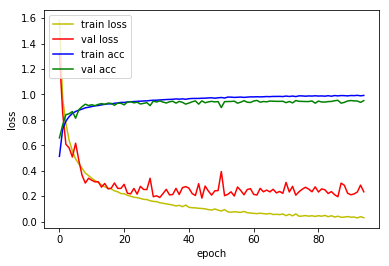

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2225 - acc: 0.9385
Loss: 0.22249647387586774 Accuracy: 0.93852544

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2767 - acc: 0.6105
Epoch 00001: val_loss improved from inf to 0.92527, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_7_conv_checkpoint/001-0.9253.hdf5
36805/36805 [==============================] - 121s 3ms/sample - loss: 1.2766 - acc: 0.6105 - val_loss: 0.9253 - val_acc: 0.7911
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5939 - acc: 0.8367
Epoch 00002: val_loss improved from 0.92527 to 0.38528, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_7_conv_checkpoint/002-0.3853.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.5939 - acc: 0.8367 - val_loss: 0.3853 - val_acc: 0.9106
Epoch 3/500
36800/36805 [====================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0655 - acc: 0.9811
Epoch 00025: val_loss did not improve from 0.12670
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0655 - acc: 0.9811 - val_loss: 0.1542 - val_acc: 0.9613
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0613 - acc: 0.9824
Epoch 00026: val_loss did not improve from 0.12670
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0613 - acc: 0.9824 - val_loss: 0.1365 - val_acc: 0.9660
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0668 - acc: 0.9808
Epoch 00027: val_loss did not improve from 0.12670
36805/36805 [==============================] - 111s 3ms/sample - loss: 0.0668 - acc: 0.9808 - val_loss: 0.1579 - val_acc: 0.9553
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0588 - acc: 0.9831
Epoch 00028: val_loss did not improve from 0.12670
36805/36805 [========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9948
Epoch 00055: val_loss did not improve from 0.12670
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0192 - acc: 0.9948 - val_loss: 0.1450 - val_acc: 0.9669
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9954
Epoch 00056: val_loss did not improve from 0.12670
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0180 - acc: 0.9954 - val_loss: 0.1637 - val_acc: 0.9644
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9945
Epoch 00057: val_loss did not improve from 0.12670
36805/36805 [==============================] - 110s 3ms/sample - loss: 0.0198 - acc: 0.9945 - val_loss: 0.2701 - val_acc: 0.9420
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9947
Epoch 00058: val_loss did not improve from 0.12670
36805/36805 [========

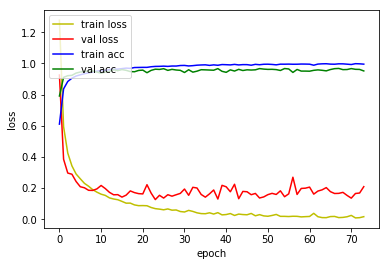

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1590 - acc: 0.9531
Loss: 0.1590009427949523 Accuracy: 0.95306337

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1994 - acc: 0.6295
Epoch 00001: val_loss improved from inf to 0.65761, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_8_conv_checkpoint/001-0.6576.hdf5
36805/36805 [==============================] - 124s 3ms/sample - loss: 1.1994 - acc: 0.6295 - val_loss: 0.6576 - val_acc: 0.7983
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4620 - acc: 0.8611
Epoch 00002: val_loss improved from 0.65761 to 0.27624, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_8_conv_checkpoint/002-0.2762.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.4620 - acc: 0.8611 - val_loss: 0.2762 - val_acc: 0.9236
Epoch 3/500
36800/36805 [=====================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9903
Epoch 00026: val_loss did not improve from 0.10365
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0332 - acc: 0.9903 - val_loss: 0.2229 - val_acc: 0.9434
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9912
Epoch 00027: val_loss did not improve from 0.10365
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0316 - acc: 0.9912 - val_loss: 0.1448 - val_acc: 0.9576
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0445 - acc: 0.9863
Epoch 00028: val_loss did not improve from 0.10365
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0445 - acc: 0.9863 - val_loss: 0.1209 - val_acc: 0.9655
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9916
Epoch 00029: val_loss did not improve from 0.10365
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9955
Epoch 00055: val_loss did not improve from 0.09905
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0147 - acc: 0.9955 - val_loss: 0.1055 - val_acc: 0.9697
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0096 - acc: 0.9971
Epoch 00056: val_loss did not improve from 0.09905
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0096 - acc: 0.9971 - val_loss: 0.1289 - val_acc: 0.9651
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9962
Epoch 00057: val_loss did not improve from 0.09905
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0123 - acc: 0.9962 - val_loss: 0.1765 - val_acc: 0.9567
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9930
Epoch 00058: val_loss did not improve from 0.09905
36805/36805 [=====================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9963
Epoch 00085: val_loss did not improve from 0.09905
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0129 - acc: 0.9963 - val_loss: 0.1046 - val_acc: 0.9723
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9994
Epoch 00086: val_loss did not improve from 0.09905
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0027 - acc: 0.9994 - val_loss: 0.1117 - val_acc: 0.9730
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0038 - acc: 0.9989
Epoch 00087: val_loss did not improve from 0.09905
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0038 - acc: 0.9989 - val_loss: 0.1914 - val_acc: 0.9609
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0073 - acc: 0.9976
Epoch 00088: val_loss did not improve from 0.09905
36805/36805 [========

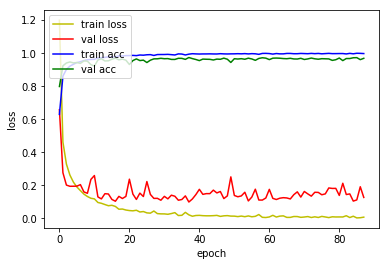

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1413 - acc: 0.9624
Loss: 0.1413172302948483 Accuracy: 0.96240914



In [10]:
base = '1D_CNN_custom_multi_2_GAP_ch_128_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GAP_ch_128_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_33[0][0]  
________________________________________________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.5631 - acc: 0.8309
Loss: 0.5630885163324025 Accuracy: 0.83094496

1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 128)   512         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activa

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2225 - acc: 0.9385
Loss: 0.22249647387586774 Accuracy: 0.93852544

1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 128)   512         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activ

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1413 - acc: 0.9624
Loss: 0.1413172302948483 Accuracy: 0.96240914


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 128)   512         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           batch_normalization_v1_33[0][0]  
________________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 4.4683 - acc: 0.3894
Loss: 4.468301856455897 Accuracy: 0.3894081

1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 128)   512         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activati

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2752 - acc: 0.9348
Loss: 0.2752117615127365 Accuracy: 0.9347871

1D_CNN_custom_multi_2_GAP_ch_128_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 128)   512         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activat

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1742 - acc: 0.9599
Loss: 0.17419907384018218 Accuracy: 0.95991695
